<a href="https://colab.research.google.com/github/fattahar/ML-Sem-7-2025/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 17 – Autoencoders, GANs, and Diffusion Models**

_This notebook contains all the sample code and solutions to the exercises in chapter 17._

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

**Warning**: the latest TensorFlow versions are based on Keras 3. For chapters 10-15, it wasn't too hard to update the code to support Keras 3, but unfortunately it's much harder for this chapter, in particular adding custom losses using the functional API is not implemented yet. So for this chapter I've had to revert to Keras 2. To do that, I set the `TF_USE_LEGACY_KERAS` environment variable to `"1"` and import the `tf_keras` package. This ensures that `tf.keras` points to `tf_keras`, which is Keras 2.*.

In [3]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tf_keras

And TensorFlow ≥ 2.8:

In [4]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/generative` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [7]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

# Performing PCA with an Undercomplete Linear Autoencoder

Let's build the Autoencoder...

In [8]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

Now let's generate the same 3D dataset as we used in Chapter 8:

In [9]:
# extra code – builds the same 3D dataset as in Chapter 8

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [10]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 9ms/step


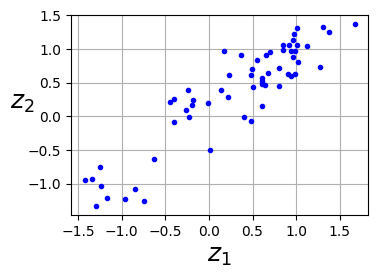

In [11]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

## Implementing a Stacked Autoencoder Using Keras

Let's load the fashion MNIST dataset, scale it, and split it into a training set, a validation set, and a test set:

In [12]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


Let's build and train a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [13]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 9s 4ms/step - loss: 0.0234 - val_loss: 0.0180
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0167 - val_loss: 0.0161
Epoch 3/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0155 - val_loss: 0.0155
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 5/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 6/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 7/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0141 - val_loss: 0.0143
Epoch 8/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0139 - val_loss: 0.0141
Epoch 9/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0137 - val_loss: 0.0139
Epoch 10/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.013

## Visualizing the Reconstructions

This function processes a few validation images through the autoencoder and displays the original images and their reconstructions:

1/1 [==============================] - 0s 58ms/step


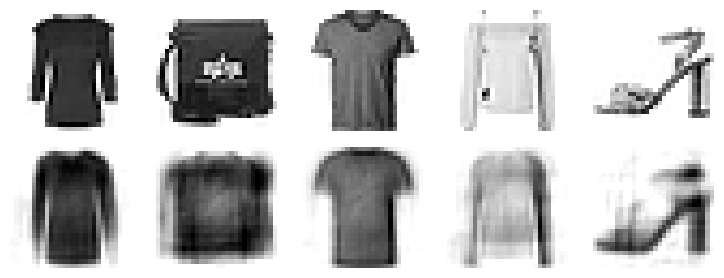

In [14]:
import numpy as np

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
save_fig("reconstruction_plot")  # extra code – saves the high res figure
plt.show()

The reconstructions look fuzzy, but remember that the images were compressed down to just 30 numbers, instead of 784.

## Visualizing the Fashion MNIST Dataset

In [15]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 1ms/step


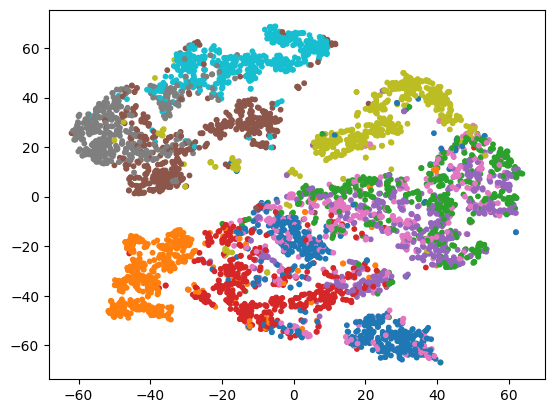

In [16]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

Let's make this diagram a bit prettier (adapted from [this Scikit-Learn example](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)):

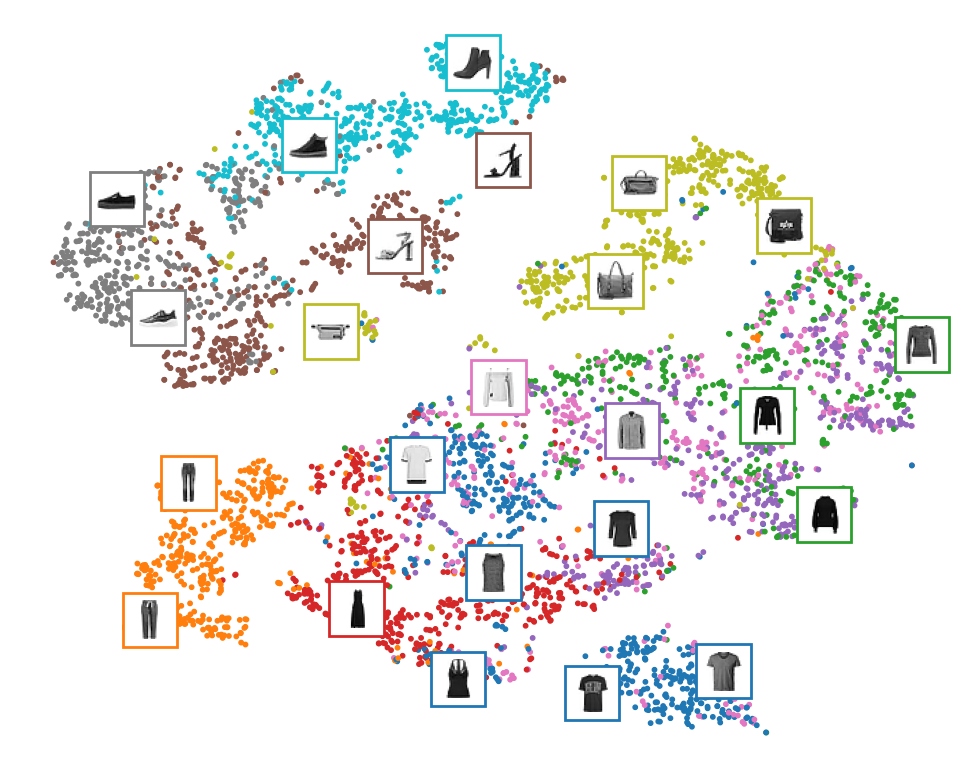

In [17]:
# extra code – beautifies the previous diagram for the book

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [18]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

**Warning**: TF seems to have a bug with `optimizer="nadam"` (training produces `nan`). I switched to using `tf.keras.optimizers.Nadam()` instead throughout this notebook.

In [19]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

# extra code – compiles and fits the model
tied_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0234 - val_loss: 0.0171
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0161 - val_loss: 0.0155
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0150 - val_loss: 0.0148
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0142 - val_loss: 0.0142
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0139 - val_loss: 0.0139
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0137 - val_loss: 0.0137
Epoch 8/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0136 - val_loss: 0.0137
Epoch 9/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 10/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.013

1/1 [==============================] - 0s 58ms/step


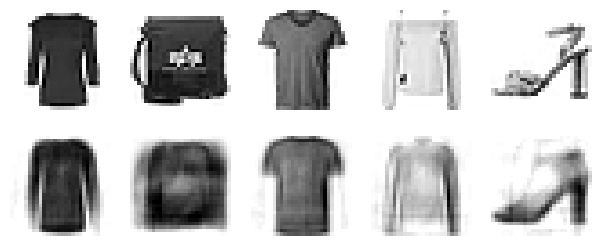

In [20]:
# extra code – plots reconstructions
plot_reconstructions(tied_ae)
plt.show()

## Extra Material – Training one Autoencoder at a Time

**Warning**: I added an extra argument for the learning rate, in order to reduce it in some cases to avoid NaN.

In [21]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=10,
                      output_activation=None, learning_rate=1e-3):
    n_inputs = X_train.shape[-1]
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    autoencoder.compile(loss="mse", optimizer=optimizer)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [22]:
tf.random.set_seed(42)

X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, learning_rate=5e-4)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, output_activation="relu",
    learning_rate=5e-3)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0227 - val_loss: 0.0134
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0116 - val_loss: 0.0106
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 8/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0087 - val_loss: 0.0094
Epoch 9/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 10/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.00

In [23]:
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 79ms/step


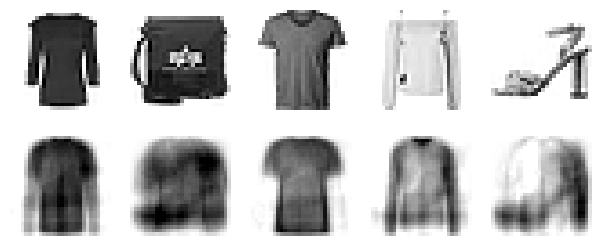

In [24]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

If needed, we can then continue training the full stacked autoencoder for a few epochs:

In [25]:
stacked_ae_1_by_1.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=5,
                                validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 9s 4ms/step - loss: 0.0214 - val_loss: 0.0201
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0189 - val_loss: 0.0181
Epoch 3/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0172 - val_loss: 0.0168
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 5/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0158 - val_loss: 0.0157


1/1 [==============================] - 0s 55ms/step


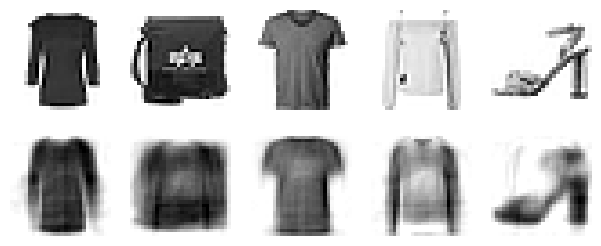

In [26]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

### **1. Stacked Autoencoders**
**Objective:** Learn efficient representations (codings) of the input data in an unsupervised manner.

**Key Details:**
* **Architecture:** Consists of an **Encoder** (compresses inputs to a lower-dimensional latent space) and a **Decoder** (reconstructs the inputs from the latent space).
* **Loss Function:** We train the model to minimize the reconstruction error (e.g., MSE between Input $X$ and Output $\hat{X}$).
* **Use Case:** Dimensionality reduction, feature extraction, and unsupervised pretraining.

## Convolutional Autoencoders

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [27]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # output: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

# extra code – compiles and fits the model
conv_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 19s 7ms/step - loss: 0.0290 - val_loss: 0.0202
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0182 - val_loss: 0.0171
Epoch 3/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.0163 - val_loss: 0.0161
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0152 - val_loss: 0.0147
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.0144 - val_loss: 0.0143
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 7/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 8/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.0129 - val_loss: 0.0133
Epoch 9/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0126 - val_loss: 0.0128
Epoch 10/10
1719/1719 [==============================] - 11s 6ms/step - l

1/1 [==============================] - 0s 263ms/step


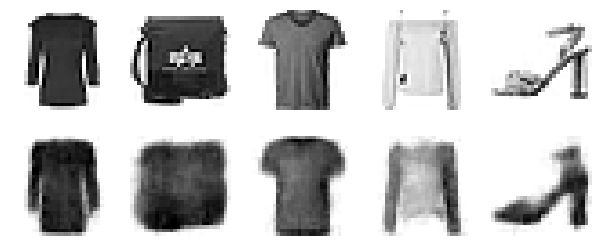

In [28]:
# extra code – shows the reconstructions
plot_reconstructions(conv_ae)
plt.show()

### **2. Convolutional Autoencoders**
**Objective:** Process images effectively by using convolutional layers instead of dense layers.

**Key Details:**
* **Encoder:** Uses `Conv2D` and `MaxPooling2D` to reduce spatial dimensions while increasing depth (number of feature maps).
* **Decoder:** Uses `Conv2DTranspose` (often called deconvolution) to upsample the image back to its original size.
* **Benefit:** Far better than Dense Autoencoders for images because they capture local spatial patterns.

# Extra Material – Recurrent Autoencoders

Let's treat each Fashion MNIST image as a sequence of 28 vectors, each with 28 dimensions:

In [29]:
tf.random.set_seed(42)

recurrent_encoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(30)
])
recurrent_decoder = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(28)
])
recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())

In [30]:
history = recurrent_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 28s 12ms/step - loss: 0.0264 - val_loss: 0.0197
Epoch 2/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0176 - val_loss: 0.0165
Epoch 3/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.0154 - val_loss: 0.0158
Epoch 4/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 5/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 6/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0125 - val_loss: 0.0122
Epoch 7/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0119 - val_loss: 0.0116
Epoch 8/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 9/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/10
1719/1719 [==============================] - 19s 11m

1/1 [==============================] - 1s 1s/step


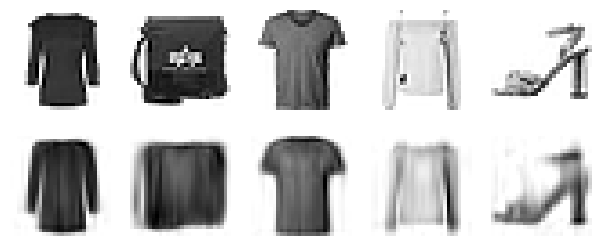

In [31]:
plot_reconstructions(recurrent_ae)
plt.show()

# Denoising Autoencoders

Using dropout:

In [32]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# extra code – compiles and fits the model
dropout_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 4ms/step - loss: 0.0289 - val_loss: 0.0218
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0222 - val_loss: 0.0199
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0211 - val_loss: 0.0192
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0205 - val_loss: 0.0188
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0200 - val_loss: 0.0184
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0197 - val_loss: 0.0183
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0195 - val_loss: 0.0179
Epoch 8/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0193 - val_loss: 0.0176
Epoch 9/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0191 - val_loss: 0.0175
Epoch 10/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.01

1/1 [==============================] - 0s 62ms/step


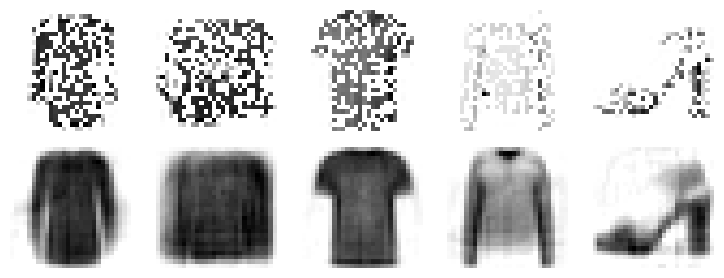

In [33]:
# extra code – this cell generates and saves Figure 17–9
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot")
plt.show()

If you want, you can try replacing the `Dropout` layer with `tf.keras.layers.GaussianNoise(0.2)`.

# Sparse Autoencoder

Let's use the sigmoid activation function in the coding layer. Let's also add $\ell_1$ regularization to it: to do this, we add an `ActivityRegularization` layer after the coding layer. Alternatively, we could add `activity_regularizer=tf.keras.regularizers.l1(1e-4)` to the coding layer itself.

In [34]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

# extra code – compiles and fits the model
sparse_l1_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.0275 - val_loss: 0.0191
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0172 - val_loss: 0.0161
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0149 - val_loss: 0.0144
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0137 - val_loss: 0.0133
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0130 - val_loss: 0.0128
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0124 - val_loss: 0.0123
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0120 - val_loss: 0.0119
Epoch 8/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0117 - val_loss: 0.0116
Epoch 9/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 10/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.011

1/1 [==============================] - 0s 63ms/step


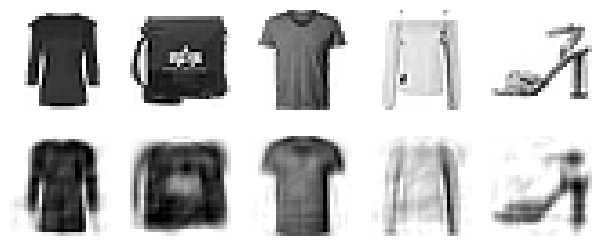

In [35]:
# extra code – shows the reconstructions
plot_reconstructions(sparse_l1_ae)
plt.show()

Let's plot the KL Divergence loss, versus the MAE and MSE:

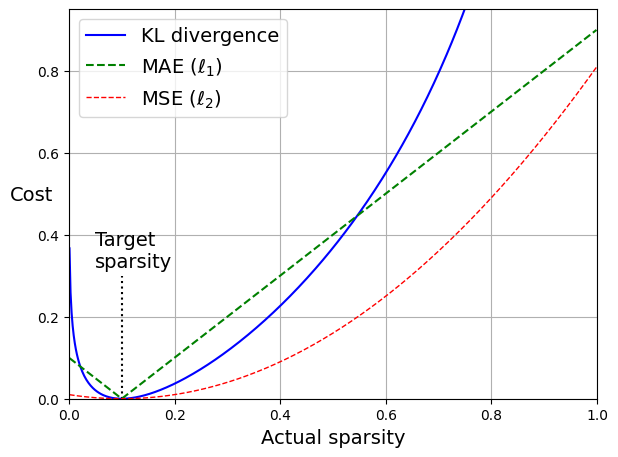

In [36]:
# extra code – this cell generates and saves Figure 17–10
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)
save_fig("sparsity_loss_plot")

Let's define a custom regularizer for KL-Divergence regularization:

In [37]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

Now let's use this regularizer to push the model to have about 10% sparsity in the coding layer:

In [38]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid",
                          activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

# extra code – compiles and fits the model
sparse_kl_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 4ms/step - loss: 0.0255 - val_loss: 0.0173
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0152 - val_loss: 0.0136
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0127 - val_loss: 0.0121
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 7/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 8/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0099 - val_loss: 0.0100
Epoch 9/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0098 - val_loss: 0.0097
Epoch 10/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.00

1/1 [==============================] - 0s 117ms/step


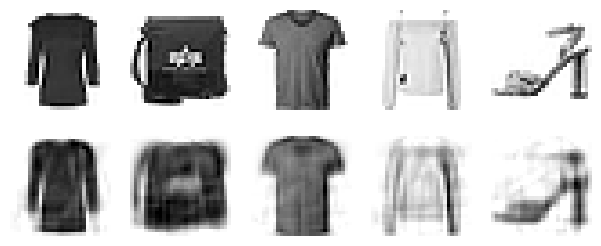

In [39]:
# extra code – shows the reconstructions
plot_reconstructions(sparse_kl_ae)
plt.show()

# Variational Autoencoder

In [40]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [41]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [42]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [43]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [44]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [45]:
variational_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 6s 6ms/step - loss: 0.0503 - val_loss: 0.0385
Epoch 2/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0364 - val_loss: 0.0356
Epoch 3/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0346 - val_loss: 0.0345
Epoch 4/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0337 - val_loss: 0.0343
Epoch 5/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0332 - val_loss: 0.0332
Epoch 6/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0327 - val_loss: 0.0331
Epoch 7/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0324 - val_loss: 0.0325
Epoch 8/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0321 - val_loss: 0.0324
Epoch 9/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0319 - val_loss: 0.0322
Epoch 10/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0318 - val_loss: 0.0321

1/1 [==============================] - 0s 153ms/step


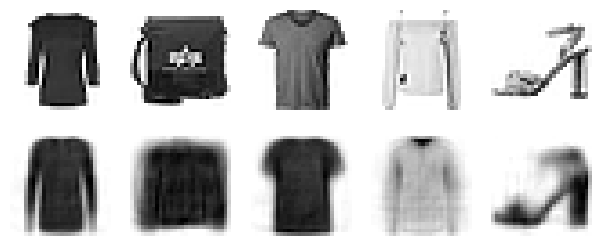

In [46]:
plot_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

Let's generate a few random codings and decode them:

In [47]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

Now let's plot these images:

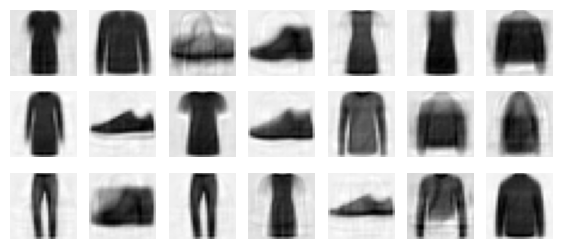

In [48]:
# extra code – this cells generates and saves Figure 17-12

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()

Now let's perform semantic interpolation between 2 images:

In [49]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)  # axis 3 looks best in this case
images = variational_decoder(codings).numpy()

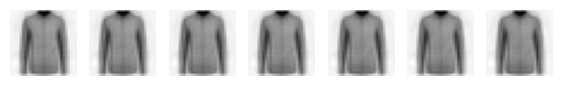

In [50]:
# extra code – this cell generates and saves Figure 17–13
plot_multiple_images(images)
save_fig("semantic_interpolation_plot", tight_layout=False)
plt.show()

# Generative Adversarial Networks

In [51]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 30

Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [52]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [53]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/5


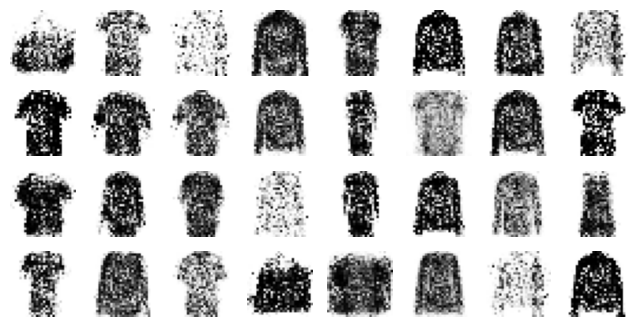

Epoch 2/5


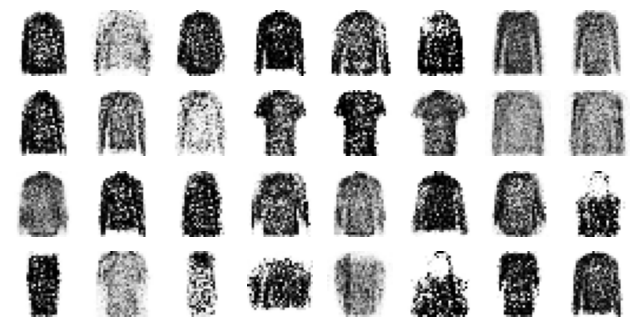

Epoch 3/5


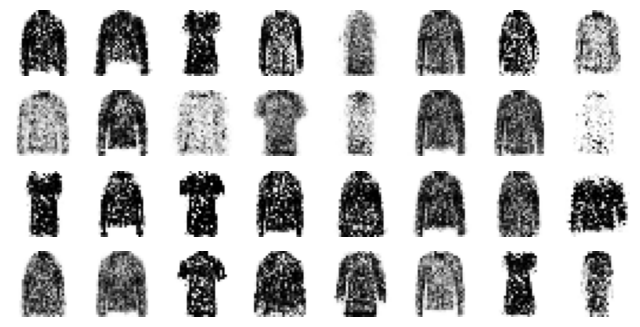

Epoch 4/5


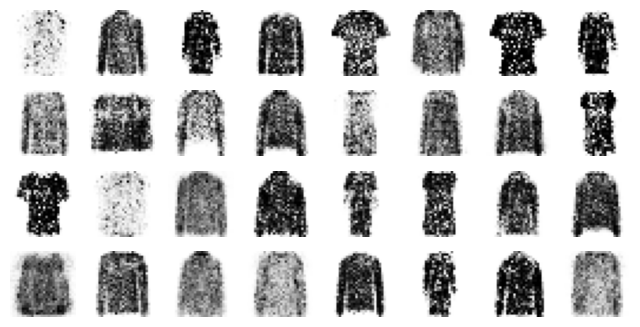

Epoch 5/5


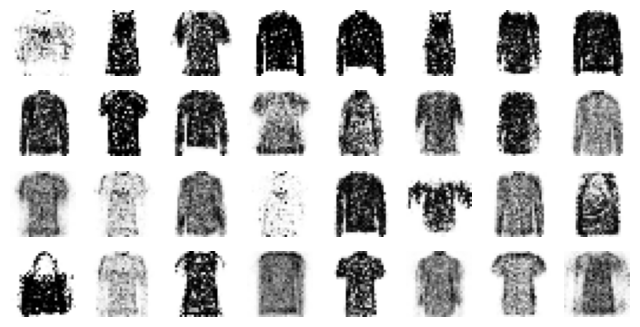

In [55]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")  # extra code
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
        # extra code — plot images during training
        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

train_gan(gan, dataset, batch_size, codings_size, n_epochs=5)

In [56]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

1/1 [==============================] - 0s 67ms/step


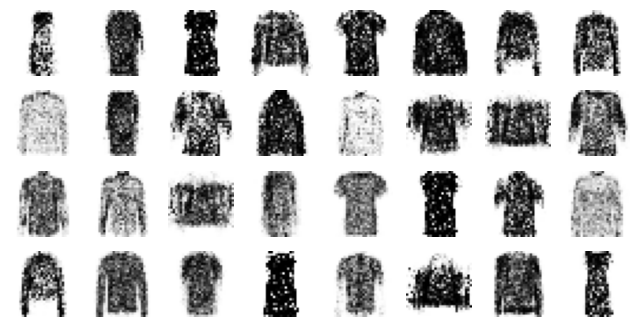

In [57]:
# extra code – this cell generates and saves Figure 17–15
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)
plt.show()

# Deep Convolutional GAN

In [58]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [59]:
# extra code – compiles the discrimator and the gan, as earlier
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [60]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

Epoch 1/5


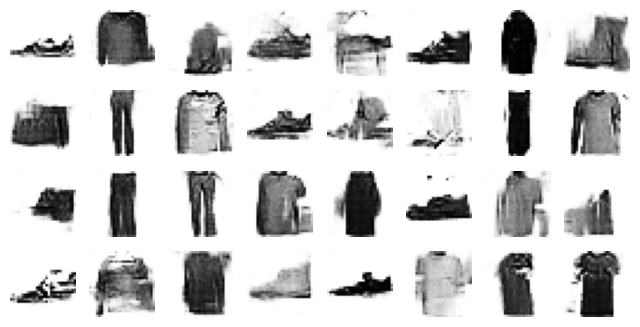

Epoch 2/5


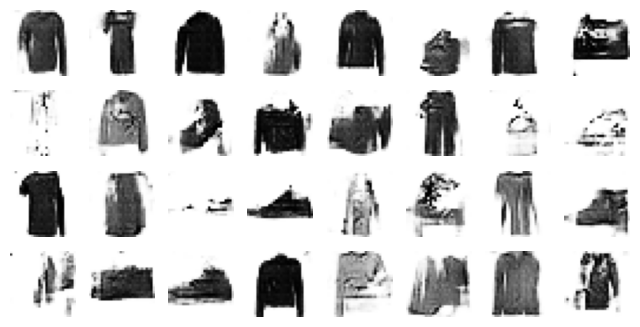

Epoch 3/5


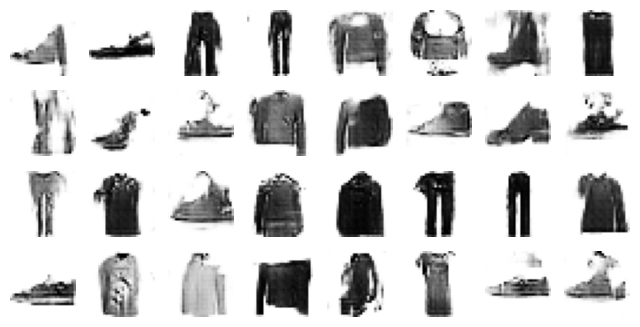

Epoch 4/5


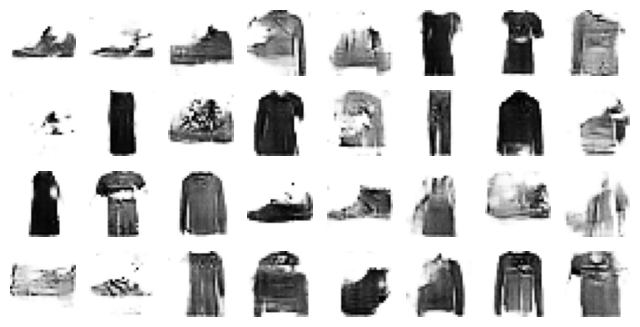

Epoch 5/5


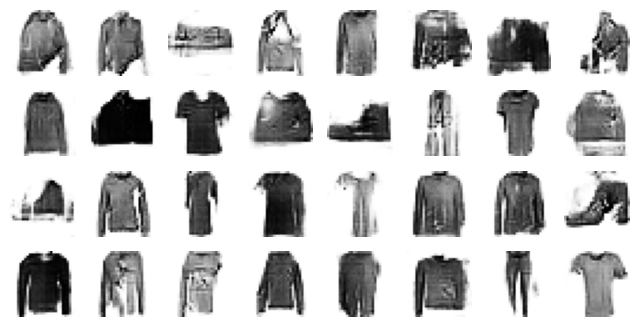

In [62]:
# extra code – generates the dataset and trains the GAN, just like earlier
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
train_gan(gan, dataset, batch_size, codings_size, n_epochs=5)

1/1 [==============================] - 0s 95ms/step


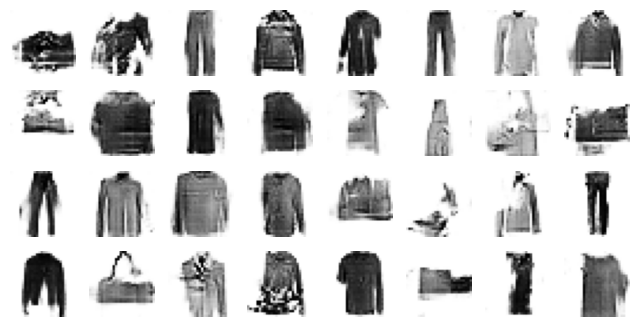

In [63]:
# extra code – this cell generates and saves Figure 17–16
tf.random.set_seed(42)
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

# Diffusion Models

Starting with an image from the dataset, at each time step $t$, the diffusion process adds Gaussian noise with mean 0 and variance $\beta_t$. The model is then trained to reverse that process. More specifically, given a noisy image produced by the forward process, and given the time $t$, the model is trained to predict the total noise that was added to the original image, scaled to variance 1.

The [DDPM paper](https://arxiv.org/abs/2006.11239) increased $\beta_t$ from $\beta_1$ = 0.0001 to $\beta_T = $0.02 ($T$ is the max step), but the [Improved DDPM paper](https://arxiv.org/pdf/2102.09672.pdf) suggested using the following $\cos^2(\ldots)$ schedule instead, which gradually decreases $\bar{\alpha_t} = \prod_{i=0}^{t} \alpha_i$ from 1 to 0, where $\alpha_t = 1 - \beta_t$:

In [64]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)  # add α₀ = 1
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta  # αₜ , α̅ₜ , βₜ for t = 0 to T

np.random.seed(42)  # extra code – for reproducibility
T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

In the DDPM paper, the authors used $T = 1,000$, while in the Improved DDPM, they bumped this up to $T = 4,000$, so we use this value. The variable `alpha` is a vector containing $\alpha_0, \alpha_1, ..., \alpha_T$. The variable `alpha_cumprod` is a vector containing $\bar{\alpha_0}, \bar{\alpha_1}, ..., \bar{\alpha_T}$.

Let's plot `alpha_cumprod`:

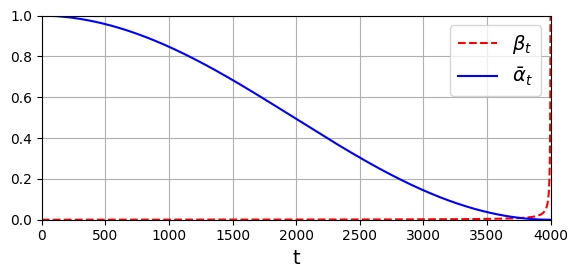

In [65]:
# extra code – this cell generates and saves Figure 17–21
plt.figure(figsize=(6, 3))
plt.plot(beta, "r--", label=r"$\beta_t$")
plt.plot(alpha_cumprod, "b", label=r"$\bar{\alpha}_t$")
plt.axis([0, T, 0, 1])
plt.grid(True)
plt.xlabel(r"t")
plt.legend()
save_fig("variance_schedule_plot")
plt.show()

The `prepare_batch()` function takes a batch of images and adds noise to each of them, using a different random time between 1 and $T$ for each image, and it returns a tuple containing the inputs and the targets:

* The inputs are a `dict` containing the noisy images and the corresponding times. The function uses equation (4) from the DDPM paper to compute the noisy images in one shot, directly from the original images. It's a shortcut for the forward diffusion process.
* The target is the noise that was used to produce the noisy images.

In [66]:
def prepare_batch(X):
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1  # scale from –1 to +1
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
    }, noise

Now let's prepare a `tf.data.Dataset` for training, and one for validation.

In [67]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

tf.random.set_seed(43)  # extra code – ensures reproducibility on CPU
train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(X_valid, batch_size=32)

As a quick sanity check, let's take a look at a few training samples, along with the corresponding noise to predict, and the original images (which we get by subtracting the appropriately scaled noise from the appropriately scaled noisy image):

Original images


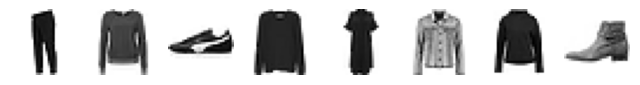

Time steps: [3405  312 3441 1991 2443 1657 3308 1151]
Noisy images


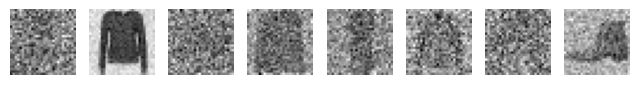

Noise to predict


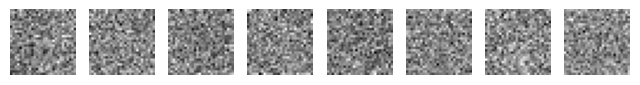

In [68]:
# extra code – just a quick sanity check

def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

X_dict, Y_noise = list(train_set.take(1))[0]  # get the first batch
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

print("Original images")
plot_multiple_images(X_original[:8].numpy())
plt.show()
print("Time steps:", X_dict["time"].numpy()[:8])
print("Noisy images")
plot_multiple_images(X_dict["X_noisy"][:8].numpy())
plt.show()
print("Noise to predict")
plot_multiple_images(Y_noise[:8].numpy())
plt.show()

Now we're ready to build the diffusion model itself. It will need to process both images and times. We will encode the times using a sinusoidal encoding, as suggested in the DDPM paper, just like in the [Attention is all you need](https://arxiv.org/abs/1706.03762) paper. Given a vector of _m_ integers representing time indices (integers), the layer returns an _m_ × _d_ matrix, where _d_ is the chosen embedding size.

In [69]:
# extra code – implements a custom time encoding layer

embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

Now let's build the model. In the Improved DDPM paper, they use a UNet model. We'll create a UNet-like model, that processes the image through `Conv2D` + `BatchNormalization` layers and skip connections, gradually downsampling the image (using `MaxPooling` layers with `strides=2`), then growing it back again (using `Upsampling2D` layers). Skip connections are also added across the downsampling part and the upsampling part. We also add the time encodings to the output of each block, after passing them through a `Dense` layer to resize them to the right dimension.

* **Note**: an image's time encoding is added to every pixel in the image, along the last axis (channels). So the number of units in the `Conv2D` layer must correspond to the embedding size, and we must reshape the `time_enc` tensor to add the width and height dimensions.
* This UNet implementation was inspired by keras.io's [image segmentation example](https://keras.io/examples/vision/oxford_pets_image_segmentation/), as well as from the [official diffusion models implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/models/unet.py). Compared to the first implementation, I added a few things, especially time encodings and skip connections across down/up parts. Compared to the second implementation, I removed a few things, especially the attention layers. It seemed like overkill for Fashion MNIST, but feel free to add them.

In [70]:
def build_diffusion_model():
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    time = tf.keras.layers.Dense(dim)(time_enc)  # adapt time encoding
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z  # add time data to every pixel

    skip = Z
    cross_skips = []  # skip connections across the down & up parts of the UNet

    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2,
                                           padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])

Let's train the model!

In [72]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU
model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Nadam())

# extra code – adds a ModelCheckpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_diffusion_model",
                                                   save_best_only=True)

history = model.fit(train_set, validation_data=valid_set, epochs=5,
                    callbacks=[checkpoint_cb])  # extra code

Epoch 1/5
1719/1719 [==============================] - 76s 29ms/step - loss: 0.1067 - val_loss: 0.0744
Epoch 2/5
1719/1719 [==============================] - 50s 29ms/step - loss: 0.0644 - val_loss: 0.0608
Epoch 3/5
1719/1719 [==============================] - 59s 34ms/step - loss: 0.0540 - val_loss: 0.0522
Epoch 4/5
1719/1719 [==============================] - 53s 31ms/step - loss: 0.0494 - val_loss: 0.0493
Epoch 5/5
1719/1719 [==============================] - 54s 32ms/step - loss: 0.0469 - val_loss: 0.0467


Now that the model is trained, we can use it to generate new images. For this, we just generate Gaussian noise, and pretend this is the result of the diffusion process, and we're at time $T$. Then we use the model to predict the image at time $T - 1$, then we call it again to get $T - 2$, and so on, removing a bit of noise at each step. At the end, we get an image that looks like it's from the Fashion MNIST dataset. The equation for this reverse process is at the top of page 4 in the DDPM paper (step 4 in algorithm 2).

In [73]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # extra code – show progress
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU
X_gen = generate(model)  # generated images

t = 1 

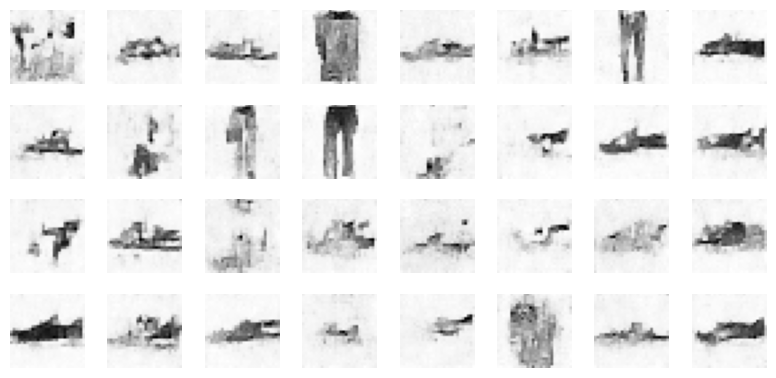

In [74]:
plot_multiple_images(X_gen.numpy(), 8)
save_fig("ddpm_generated_images_plot")
plt.show()

Some of these images are really convincing! Compared to GANs, diffusion models tend to generate more diverse images, and they have surpassed GANs in image quality. Moreover, training is much more stable. However, generating images takes *much* longer.

# Extra Material – Hashing Using a Binary Autoencoder

Let's train an autoencoder where the encoder has a 16-neuron output layer, using the sigmoid activation function, and heavy Gaussian noise just before it. During training, the noise layer will encourage the previous layer to output large values, since small values will just be crushed by the noise. In turn, this means that the output layer will output values close to 0 or 1, thanks to the sigmoid activation function. Once we round the output values to 0s and 1s, we get a 16-bit "semantic" hash. If everything works well, images that look alike will have the same hash. This can be very useful for search engines: for example, if we store each image on a server identified by the image's semantic hash, then all similar images will end up on the same server. Users of the search engine can then provide an image to search for, and the search engine will compute the image's hash using the encoder, and quickly return all the images on the server identified by that hash.

In [75]:
tf.random.set_seed(42)

hashing_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.GaussianNoise(15.),
    tf.keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
hashing_ae = tf.keras.Sequential([hashing_encoder, hashing_decoder])
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
hashing_ae.compile(loss="mse", optimizer=optimizer)
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.0616 - val_loss: 0.0583
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0465 - val_loss: 0.0542
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0430 - val_loss: 0.0511
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0411 - val_loss: 0.0502
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0395 - val_loss: 0.0446
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0383 - val_loss: 0.0443
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0373 - val_loss: 0.0432
Epoch 8/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0366 - val_loss: 0.0408
Epoch 9/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0359 - val_loss: 0.0395
Epoch 10/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.035

The autoencoder compresses the information so much (down to 16 bits!) that it's quite lossy, but that's okay, we're using it to produce semantic hashes, not to perfectly reconstruct the images:

1/1 [==============================] - 0s 87ms/step


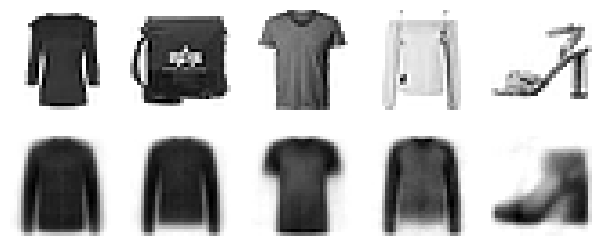

In [76]:
plot_reconstructions(hashing_ae)
plt.show()

Now let's see what the hashes look like for the first few images in the validation set:

In [77]:
hashes = hashing_encoder.predict(X_valid).round().astype(np.int32)
hashes *= np.array([[2 ** bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print(f"{h:016b}")
print("...")

157/157 [==============================] - 0s 2ms/step
1001111110100011
1001111110100010
1101111110000111
1001111100000010
1001111010010000
...


Now let's find the most common image hashes in the validation set, and display a few images for each hash. In the following image, all the images on a given row have the same hash:

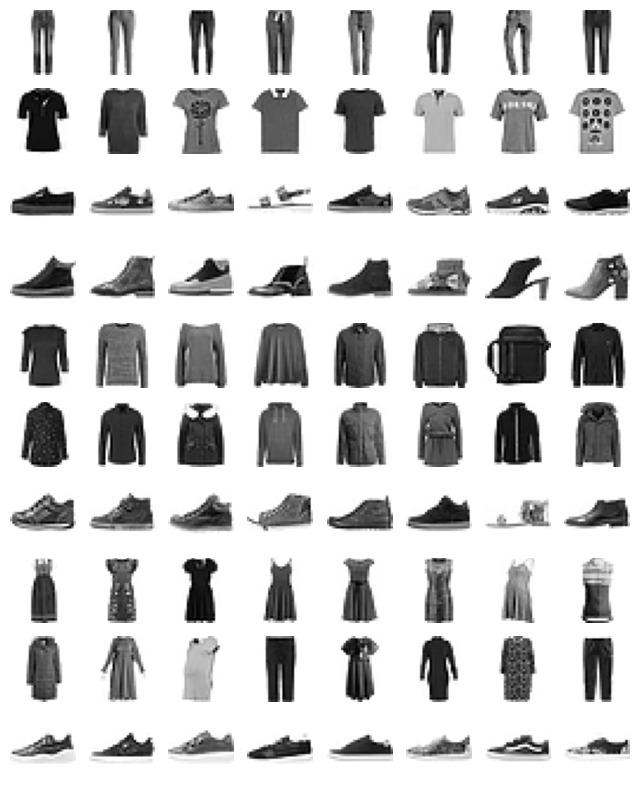

In [78]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plt.show()

### **3. Variational Autoencoders (VAEs)**
**Objective:** A generative model that learns the *probability distribution* of the training data.

**Key Details:**
* **Probabilistic:** Instead of mapping an input to a fixed point, the encoder outputs a mean $\mu$ and log-variance $\gamma$.
* **Reparameterization Trick:** To allow backpropagation through random sampling, we sample $\epsilon \sim \mathcal{N}(0, 1)$ and compute $z = \mu + \sigma \cdot \epsilon$.
* **Loss:** Includes a **KL Divergence** term to force the latent distribution to look like a standard Gaussian.

### **4. Generative Adversarial Networks (GANs)**
**Objective:** Generate realistic data by pitting two networks against each other.

**Key Details:**
* **Generator:** Tries to generate fake data that looks real to fool the discriminator.
* **Discriminator:** Tries to distinguish between real data (from the dataset) and fake data (from the generator).
* **Zero-Sum Game:** Training is difficult because the networks constantly try to outsmart each other (Nash Equilibrium).

### **5. Denoising Diffusion Probabilistic Models (DDPMs)**
**Objective:** Generate high-quality images by learning to reverse a gradual noise process.

**Key Details:**
* **Forward Process:** Slowly adds Gaussian noise to an image until it becomes pure noise.
* **Reverse Process:** The model (typically a **U-Net**) learns to predict the noise that was added at each time step $t$. By subtracting this predicted noise, it can generate an image from pure noise.
* **Stability:** Diffusion models are more stable to train than GANs and produce more diverse samples (no Mode Collapse).

# **Chapter 17 Summary: Autoencoders, GANs, and Diffusion Models**

##

**1. Autoencoders**
* **Concept:** Unsupervised neural networks trained to copy their input to their output. To prevent trivial copying, they are constrained by a bottleneck (lower-dimensional latent space).
* **Architecture:**
    * **Encoder:** Compresses the input into a latent representation (codings).
    * **Decoder:** Reconstructs the input from the codings.
* **Convolutional Autoencoders:** Use `Conv2D` for the encoder and `Conv2DTranspose` (upsampling) for the decoder. They are far superior for image tasks compared to dense layers.


**2. Variational Autoencoders (VAEs)**
* **Generative Model:** Unlike standard autoencoders, VAEs learn a *probability distribution* of the data, allowing them to sample new, random instances.
* **Reparameterization Trick:** To allow backpropagation through random sampling, VAEs sample $\epsilon \sim \mathcal{N}(0, 1)$ and compute $z = \mu + \sigma \cdot \epsilon$.
* **Loss Function:** Minimizes reconstruction error + **KL Divergence** (which forces the latent distribution to approximate a standard Gaussian).


**3. Generative Adversarial Networks (GANs)**
* **The Game:** Two networks compete in a zero-sum game:
    * **Generator:** Tries to produce realistic data to fool the discriminator.
    * **Discriminator:** Tries to distinguish real data from fake data.
* **Training Challenges:** GANs are notoriously hard to train due to instabilities like **Mode Collapse** (where the generator produces the same image over and over) and the difficulty of reaching Nash Equilibrium.


**4. Diffusion Models (DDPMs)**
* **Concept:** Inspired by thermodynamics, these models destroy data by slowly adding noise (Forward Process), then learn to reverse this process to recover data from pure noise (Reverse Process).
* **Mechanism:** The model (typically a **U-Net**) is trained to predict the noise added at each time step $t$.
* **Pros/Cons:** They produce higher quality and more diverse images than GANs and are more stable to train, but sampling is slow because it requires hundreds of iterative steps.